In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
from pathlib import Path

DATA_DIR = Path('../backend/api/data')
RAW_DATA = DATA_DIR / 'raw'
PROCESSED_DATA = DATA_DIR / 'processed'
INFOBUSES = RAW_DATA / 'buses'

df = pd.read_excel(RAW_DATA / 'paraderos_2018-1.xlsx')
print(df.columns)
df.head()

Index(['Orden\nCirc.', 'Código TS', 'Código Usuario', 'Sentido Servicio',
       'Varian-te', 'UN', 'Código paradero TS', 'Código  paradero Usuario',
       'Comuna', 'Eje', 'Desde ( Cruce 1)', 'Hacia ( Cruce 2)', 'x', 'y',
       'Nombre Paradero', 'Operación con Zona Paga',
       'Paradas con Excepciones'],
      dtype='object')


,Orden\nCirc.,Código TS,Código Usuario,Sentido Servicio,Varian-te,UN,Código paradero TS,Código paradero Usuario,Comuna,Eje,Desde ( Cruce 1),Hacia ( Cruce 2),x,y,Nombre Paradero,Operación con Zona Paga,Paradas con Excepciones
0,1,201,201,Ida,NaN,2,T-3-374-NS-5,PB241,HUECHURABA,LOS LIBERTADORES,SANTA ELENA,SANTA ELENA DE HUECHURABA,343574.6,6307088.8,Parada / Mall Plaza Norte - Los Libertadores,NaN,NaN
1,2,201,201,Ida,NaN,2,T-3-374-NS-10,PB184,HUECHURABA,LOS LIBERTADORES,CALLE NUEVA,AVENIDA AMÉRICO VESPUCIO,343614.4,6306782.2,Los Libertadores / esq. Av. A. Vespucio,NaN,NaN
2,3,201,201,Ida,NaN,2,T-3-12-OP-75,PB185,HUECHURABA,AVENIDA AMÉRICO VESPUCIO,AGUA MARINA,GENERAL SAN MARTÍN,343164.4,6306858.5,Parada / Pasarela Albany,NaN,NaN
3,4,201,201,Ida,NaN,2,T-2-3-NS-4,PB242,CONCHALÍ,AVENIDA INDEPENDENCIA,AVENIDA AMÉRICO VESPUCIO,AVENIDA AMÉRICO VESPUCIO,342809.3,6306823.6,Parada 6 / (M) Los Libertadores,Zona Paga,NaN
4,5,201,201,Ida,NaN,2,T-2-3-NS-10,PB186,CONCHALÍ,AVENIDA INDEPENDENCIA,FORESTAL,HÉROES DE IQUIQUE,342901.4,6306514.2,Av. Independencia / esq. H. de Iquique,NaN,NaN


# Análisis de los datos

In [3]:
df['Código TS'].value_counts()

Código TS
514     607
568     473
505     414
508     405
576     375
       ... 
521c     15
B70      13
350c     10
378c      8
374e      2
Name: count, Length: 380, dtype: int64

In [4]:
# cantidad de recorridos
print("Existen un total de {} recorridos descritos".format(len(df['Código TS'].value_counts()) / 2))

Existen un total de 190.0 recorridos descritos


In [5]:
df['Varian-te'].value_counts()

Varian-te
PRN     4646
PM      3427
PT      1061
N        873
TNOC     143
PMPT      61
Name: count, dtype: int64

In [6]:
df['Sentido Servicio'].value_counts()

Sentido Servicio
Ida    23876
Ret    22075
ida        6
Name: count, dtype: int64

<Axes: >

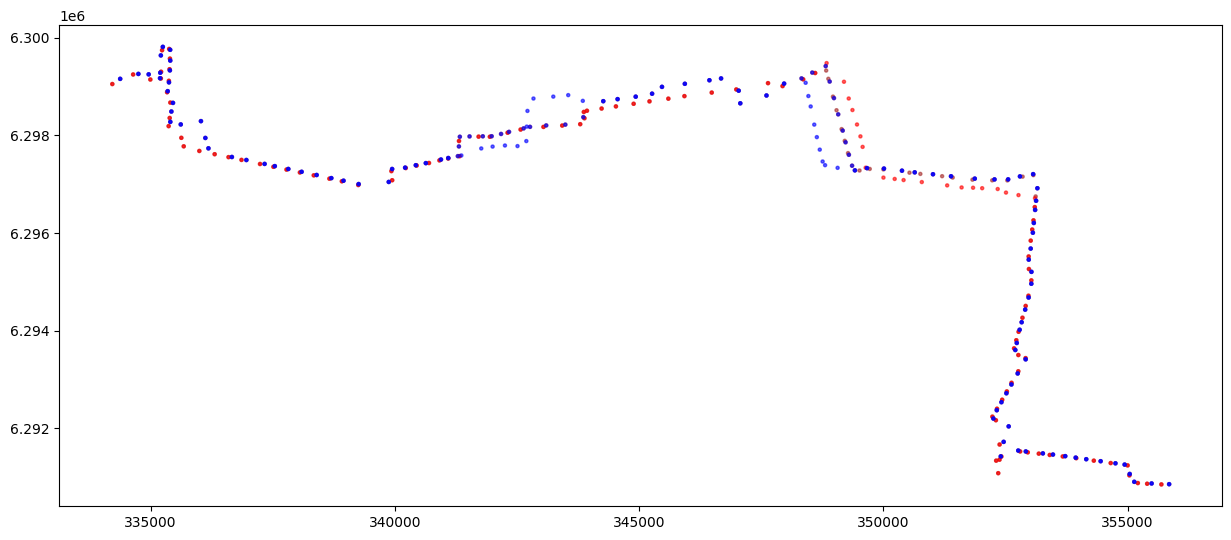

In [7]:
from shapely import Point

paraderos = df[df['Código TS'] == 514]
def getColor(punto):
    if(not pd.notna(punto['Varian-te'])):
        return 'brown'
    elif(punto['Sentido Servicio'] == 'Ida' or punto['Sentido Servicio'] == 'ida'):
        return 'red'
    elif(punto['Sentido Servicio'] == 'Ret'):
        return 'blue'
    else: 
        return 'green'
colores = paraderos.apply(getColor, axis=1)
geom =  paraderos.apply(lambda row: Point(row['x'], row['y']), axis=1)
geopd = gpd.GeoDataFrame(data=paraderos.drop(columns=['x', 'y']), geometry=geom, crs='epsg:5361')

geopd.plot(color=colores, markersize=5, alpha=0.6, figsize=(15,15))

In [8]:
geo2 = geopd.to_crs('EPSG:9152')
clean = geo2.drop(columns=['Orden\nCirc.', 
                           'Sentido Servicio', 
                           'Varian-te', 
                           'UN', 
                           'Código TS',
                           'Código Usuario',
                           'Comuna',
                           'Eje',
                           'Desde ( Cruce 1)',
                           'Hacia ( Cruce 2)',
                           'Operación con Zona Paga',
                           'Paradas con Excepciones'
                           ])
uniques = clean.drop_duplicates(subset=['Código paradero TS'], keep='first')

uniques

,Código paradero TS,Código paradero Usuario,Nombre Paradero,geometry
32404,L-10-55-13-OP,PJ1801,Río Clarillo / esq. Av. A. Vespucio,POINT (-70.78336 -33.43514)
32405,L-10-55-5-PO,PJ1055,Río Clarillo / esq. Salar de Ascotán,POINT (-70.77874 -33.43344)
32406,L-10-54-5-NS,PJ1052,Salar de Surire / esq. María Angélica,POINT (-70.77497 -33.43443)
32407,POR DEFINIR,POR DEFINIR,Riva Riva / José Manuel Guzmán,POINT EMPTY
32408,L-10-37-35-SN,PJ681,J. M. Guzmán Riesco / esq. Iorana,POINT (-70.77265 -33.43427)
...,...,...,...,...
32945,T-14-132-SN-5,PC580,Seminario / esq. Santa Isabel,POINT (-70.62847 -33.44707)
32946,T-14-132-SN-10,PC581,Seminario / esq. Marín,POINT (-70.62899 -33.44475)
32947,T-14-132-SN-15,PC559,Seminario / esq. Rancagua,POINT (-70.62972 -33.44139)
32948,T-14-132-SN-20,PC560,Seminario / esq. María L. Santander,POINT (-70.63019 -33.43947)


In [9]:
defined_code = df['Código paradero TS'] != 'POR DEFINIR'
defined_x = df['x'] != 'POR DEFINIR'
defined_y = df['y'] != 'POR DEFINIR'

defined = df[defined_code & defined_y & defined_x]

bus_stops = defined.drop_duplicates(keep='first', subset=['Código paradero TS'])

# well_place = defined[defined['x'].apply(float) > 100]

geom =  bus_stops.apply(lambda row: Point(row['x'], row['y']), axis=1)
geopd = gpd.GeoDataFrame(data=bus_stops.drop(columns=[
    'x', 
    'y', 
    'Orden\nCirc.', 
    'Sentido Servicio', 
    'Varian-te', 
    'UN', 
    'Código TS',
    'Código Usuario',
    'Comuna',
    'Eje',
    'Desde ( Cruce 1)',
    'Hacia ( Cruce 2)',
    'Operación con Zona Paga',
    'Paradas con Excepciones'
    ]), geometry=geom, crs='epsg:5361')
geopd['Código paradero TS'].value_counts()

Código paradero TS
T-3-374-NS-5      1
L-17-25-5-NS      1
L-16-13-15-PO     1
L-16-13-25-PO     1
L-16-12-10-PO     1
                 ..
L-33-26-20-NS     1
L-33-23-60-OP     1
L-33-23-55-OP     1
L-33-4-10-NS      1
T-17-140-OP-32    1
Name: count, Length: 11310, dtype: int64

<Axes: >

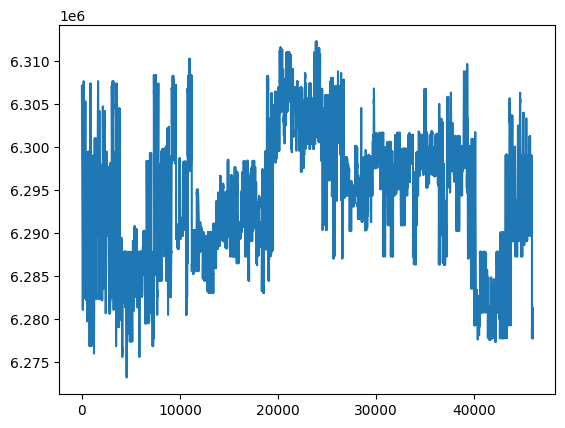

In [10]:
# defined['x'].astype(float).plot()
defined['y'].astype(float).plot()

<Axes: >

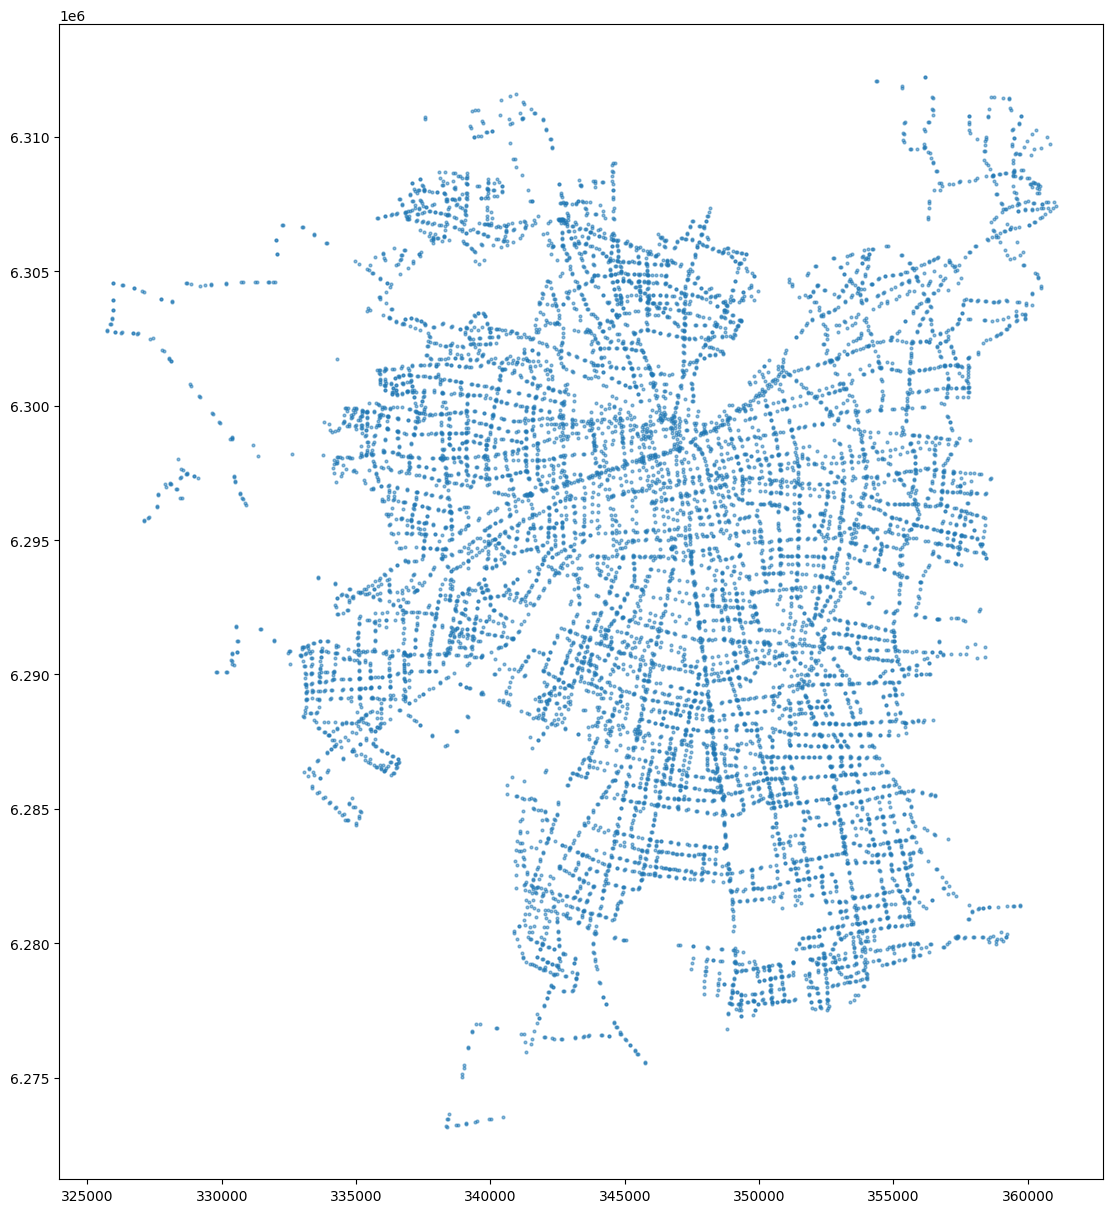

In [11]:
geopd.plot(alpha=0.5, markersize=4, figsize=(15, 15))

<Axes: >

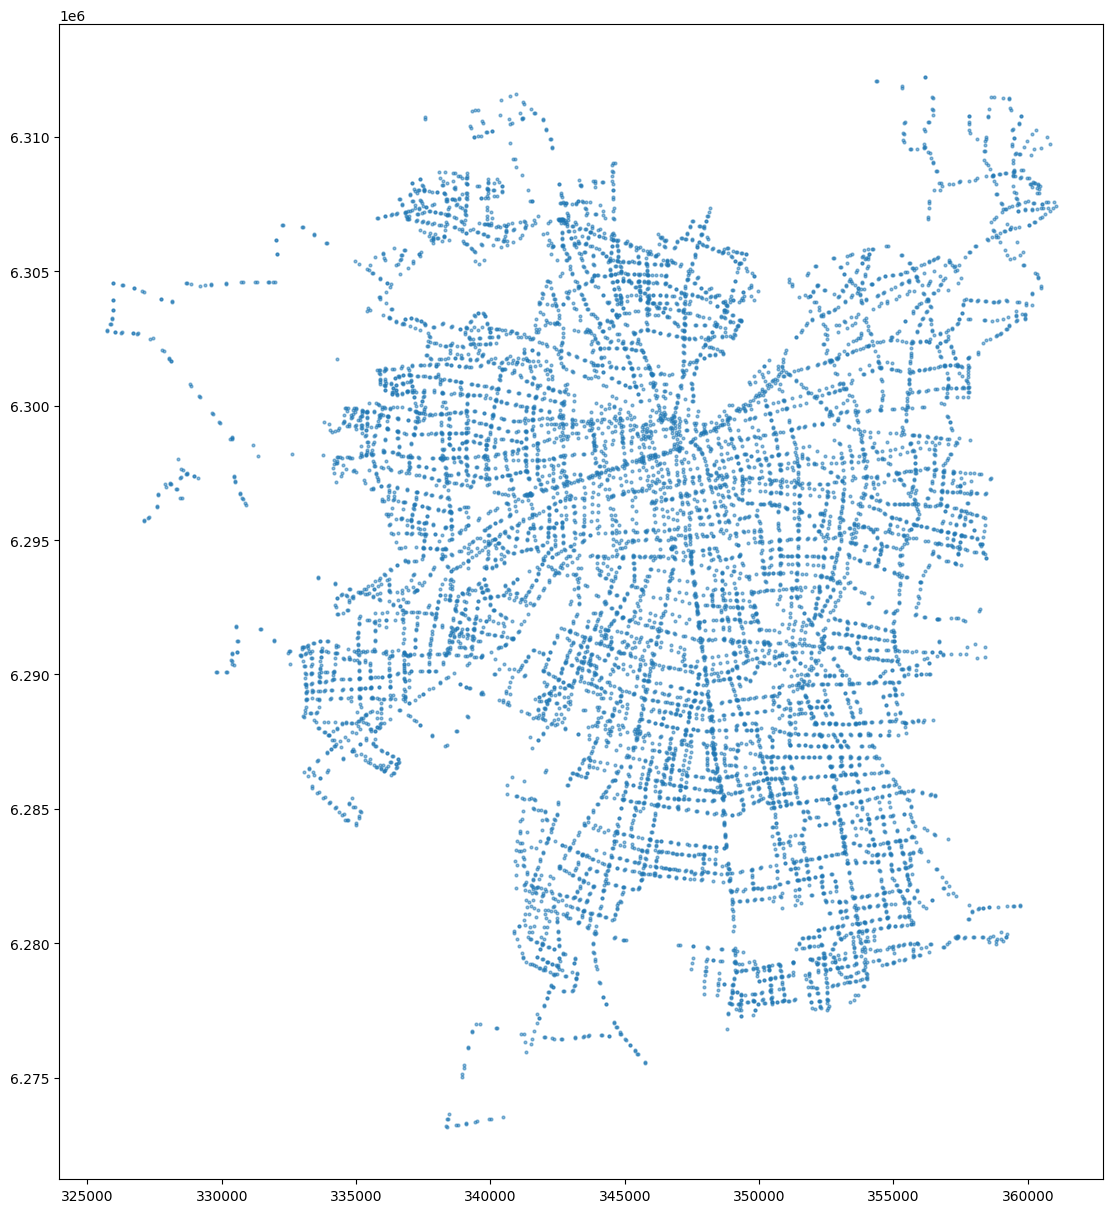

In [12]:
geopd.drop_duplicates(subset=['Código paradero TS']).plot(alpha=0.5, markersize=4, figsize=(15, 15))